In [2]:
import pandas as pd
import numpy as np
import sklearn
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math

#### reference
https://www.kaggle.com/onlyshadow/a-practical-guide-to-ny-taxi-data-0-379 

In [157]:
path=os.getenv('HOME')+'/aiffel/kaggle/taxi_trip_duration/'

raw_train=pd.read_csv(path+'train.csv')
raw_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [161]:
raw_test=pd.read_csv(path+'test.csv')

x_train=raw_train.loc[:,:'trip_duration']
data=pd.concat([x_train, raw_test])

id - a unique identifier for each trip   
vendor_id - a code indicating the provider associated with the trip record   
pickup_datetime - date and time when the meter was engaged   
dropoff_datetime - date and time when the meter was disengaged   
passenger_count - the number of passengers in the vehicle (driver entered value)   
pickup_longitude - the longitude where the meter was engaged   
pickup_latitude - the latitude where the meter was engaged   
dropoff_longitude - the longitude where the meter was disengaged   
dropoff_latitude - the latitude where the meter was disengaged   
store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip   
trip_duration - duration of the trip in seconds   

# 1. Preprocessing

## 1) Missing value : 결측값 제거하기

In [164]:
raw_train.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [165]:
raw_test.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

In [174]:
train.pickup_datetime=pd.to_datetime(train.pickup_datetime)
train.dropoff_datetime=pd.to_datetime(train.dropoff_datetime)
data.pickup_datetime=pd.to_datetime(data.pickup_datetime)
data.dropoff_datetime=pd.to_datetime(data.dropoff_datetime)

## 2) Duplicates : 데이터 중복

In [175]:
raw_train.loc['passenger_count':].duplicated().sum()

0

In [176]:
raw_test.loc['passenger_count': ].duplicated().sum()

0

## 3) Normalization : 정규화

<AxesSubplot:>

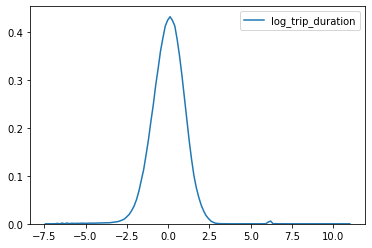

In [177]:
data['log_trip_duration']=np.log(data['trip_duration']+1)
data['log_trip_duration']=(data['log_trip_duration']-np.mean(data['log_trip_duration']))/np.std(data['log_trip_duration'])
sns.kdeplot(data['log_trip_duration'])

# 2. Feature Engineering

## 1. Extra feature (피처 추가하기)

### 1) 이동거리

In [178]:
data['distance_travel_l1']=abs(data.pickup_longitude-data.dropoff_longitude)+abs(data.pickup_latitude-data.dropoff_latitude)
data['distance_travel_l2']=np.sqrt((data.pickup_longitude-data.dropoff_longitude)**2+(data.pickup_latitude-data.dropoff_latitude)**2)

In [179]:
data.distance_travel_l2

0         0.017680
1         0.020456
2         0.059934
3         0.013438
4         0.010690
            ...   
625129    0.008819
625130    0.065581
625131    0.096318
625132    0.199944
625133    0.053970
Name: distance_travel_l2, Length: 2083778, dtype: float64

### 2) Date & Weekends 

In [180]:
data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,distance_travel_l1,distance_travel_l2
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455.0,-0.432902,0.019859,0.017680
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663.0,0.039338,0.026478,0.020456
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124.0,1.501143,0.080158,0.059934
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429.0,-0.506677,0.015480,0.013438
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435.0,-0.489264,0.010818,0.010690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625129,id3008929,1,2016-01-01 00:02:52,NaT,1,-74.003464,40.725105,-74.001251,40.733643,N,NaN,NaN,0.010750,0.008819
625130,id3700764,1,2016-01-01 00:01:52,NaT,1,-74.006363,40.743782,-73.953407,40.782467,N,NaN,NaN,0.091640,0.065581
625131,id2568735,1,2016-01-01 00:01:24,NaT,2,-73.972267,40.759865,-73.876602,40.748665,N,NaN,NaN,0.106865,0.096318
625132,id1384355,1,2016-01-01 00:00:28,NaT,1,-73.976501,40.733562,-73.854263,40.891788,N,NaN,NaN,0.280464,0.199944


In [181]:
data['year']=data.pickup_datetime.dt.year
data['month']=data.pickup_datetime.dt.month
data['date']=data.pickup_datetime.dt.day

In [182]:
data['weekday']=data.pickup_datetime.dt.weekday
data.weekday

0         0
1         6
2         1
3         2
4         5
         ..
625129    4
625130    4
625131    4
625132    4
625133    4
Name: weekday, Length: 2083778, dtype: int64

In [183]:
data['holiday']=0
data.loc[data['weekday']==5, 'holiday']=1
data.loc[data['weekday']==6, 'holiday']=1

### 3) Time of a day

In [184]:
data['hour']=data.pickup_datetime.dt.hour
data['minute']=data.pickup_datetime.dt.minute

In [185]:
data['time']=data.hour+data.minute/60

### 4) Pickup Location

In [186]:
import sklearn.cluster
from sklearn.cluster import KMeans

In [187]:
pickup_loc=data[['pickup_longitude', 'pickup_latitude']].values
dropoff_loc=data[['dropoff_longitude', 'dropoff_latitude']].values
move=np.hstack((pickup_loc, dropoff_loc))
kmeans=KMeans(n_clusters=10)
kmeans.fit(move)

KMeans(n_clusters=10)

In [188]:
pickup_loc.shape
data.shape

(2083778, 22)

In [189]:
len(pd.Series(kmeans.labels_))

2083778

In [190]:
data['kmeans']=pd.Series(kmeans.labels_)

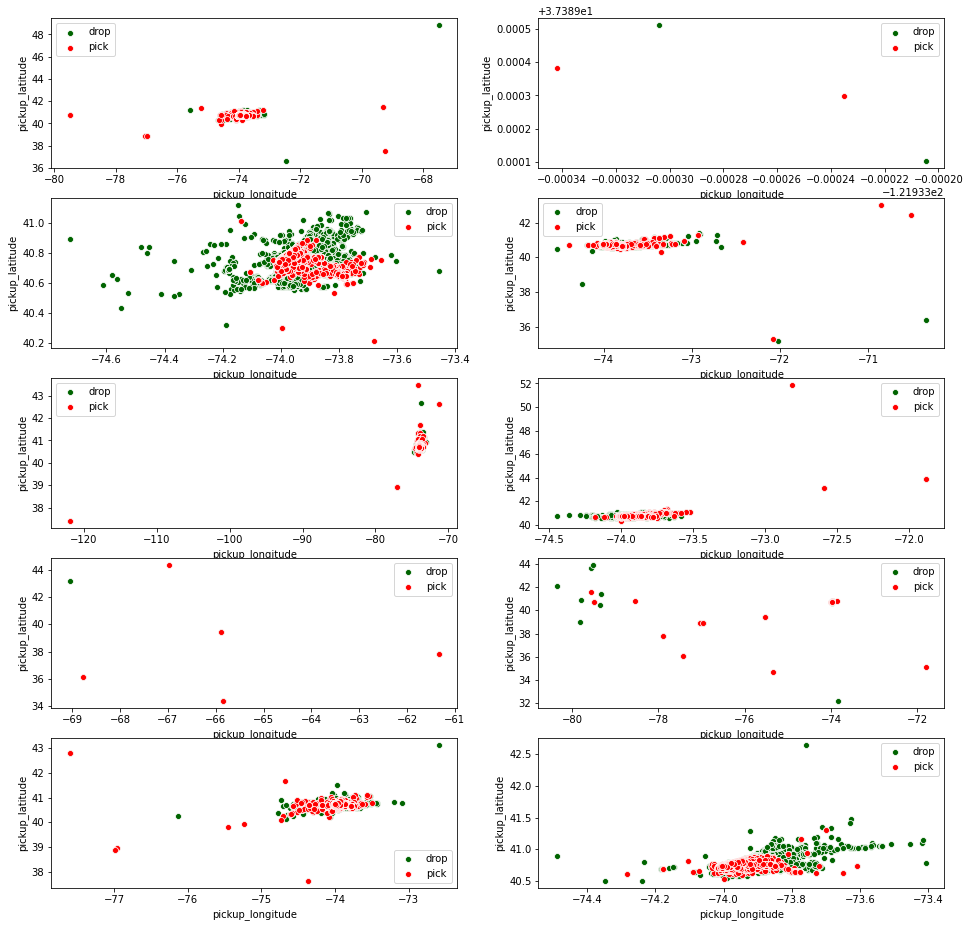

In [191]:
fig=plt.figure(figsize=(16,16))
for i in range(10):
    plt.subplot(5,2,i+1)
    sns.scatterplot('dropoff_longitude', 'dropoff_latitude',data=data[data['kmeans']==i], marker='o', color='darkgreen', label='drop')
    sns.scatterplot('pickup_longitude', 'pickup_latitude',data=data[data['kmeans']==i], marker='o', color='red', label='pick')
    plt.legend()

# 3. 이상치 제거 -> 미진행

## 1) 속도 이상치

In [192]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,distance_travel_l2,year,month,date,weekday,holiday,hour,minute,time,kmeans
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0.017680,2016,3,14,0,0,17,24,17.400000,4
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0.020456,2016,6,12,6,1,0,43,0.716667,8
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,0.059934,2016,1,19,1,0,11,35,11.583333,8
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,0.013438,2016,4,6,2,0,19,32,19.533333,8
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,0.010690,2016,3,26,5,1,13,30,13.500000,4


In [195]:
raw_train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

이상치로 감지될 수 있는 지표들은 거리와 소요 시간 (속도가 너무 느리거나 빠른 경우) 로 볼 수 있다. 해당 지표를 살펴보자

<AxesSubplot:xlabel='distance_travel_l1', ylabel='trip_duration'>

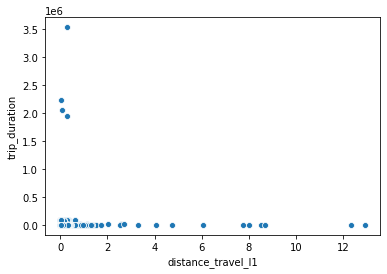

In [196]:
sns.scatterplot(x='distance_travel_l1', y='trip_duration', data=data)

<AxesSubplot:xlabel='distance_travel_l2', ylabel='trip_duration'>

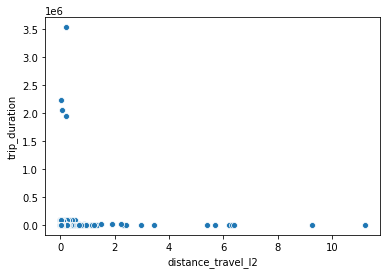

In [197]:
sns.scatterplot(x='distance_travel_l2', y='trip_duration', data=data)

<AxesSubplot:xlabel='distance_travel_l1', ylabel='trip_duration'>

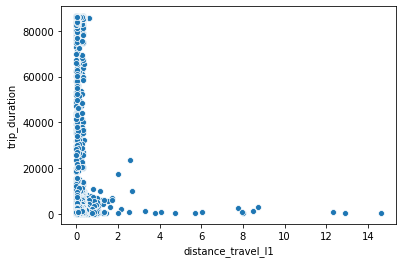

In [401]:
sns.scatterplot(x='distance_travel_l1', y='trip_duration', data=data)

이상치를 제거한 뒤에도, 여전히 거리와 소요시간 간의 큰 상관관계를 알 수 없다.   
속도와 시간의 관계를 살펴보자   

변수추가 ; avg_speed_l2 (유클리디안 거리 / 실제 소요 시간)

In [199]:
data['avg_speed_l2']=data['distance_travel_l2']/data['trip_duration']

<AxesSubplot:>

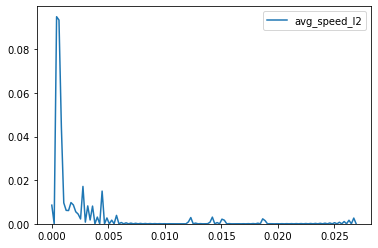

In [200]:
sns.kdeplot(data['avg_speed_l2'])

<AxesSubplot:xlabel='hour', ylabel='avg_speed_l2'>

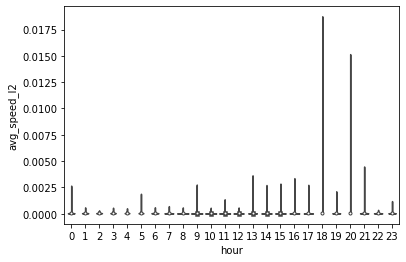

In [201]:
weekday_train=data[data['holiday']==0]
sns.violinplot(x='hour', y='avg_speed_l2',data=weekday_train)

<AxesSubplot:xlabel='hour', ylabel='avg_speed_l2'>

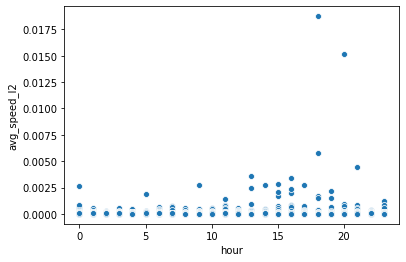

In [202]:
weekday_train=data[data['holiday']==0]
sns.scatterplot(x='hour', y='avg_speed_l2',data=weekday_train)

<AxesSubplot:xlabel='hour', ylabel='avg_speed_l2'>

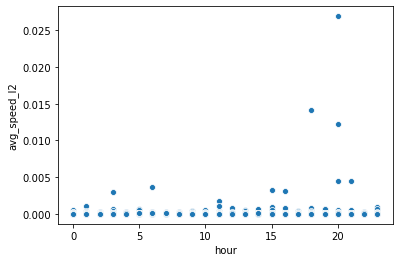

In [203]:
holiday_train=data[data['holiday']==1]
sns.scatterplot(x='hour', y='avg_speed_l2',data=holiday_train)

<AxesSubplot:xlabel='hour', ylabel='avg_speed_l2'>

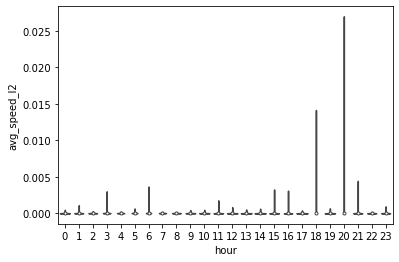

In [204]:
holiday_train=data[data['holiday']==1]
sns.violinplot(x='hour', y='avg_speed_l2',data=holiday_train)

18시 - 21시 사이에 특히 속도가 빠른 특이 값들이 도출되는것으로 보인다.   
해당 값들을 살펴보면 다음과 같다

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,year,month,date,weekday,holiday,hour,minute,time,kmeans,avg_speed_l2
184925,id2306955,1,2016-05-07 18:58:53,2016-05-07 19:12:05,1,-72.809669,51.881084,-73.987228,40.750599,N,...,2016,5,7,5,1,18,58,18.966667,0,0.014132
377068,id0116374,1,2016-04-02 20:33:19,2016-04-02 20:38:01,1,-74.007095,40.717113,-76.963242,38.946033,N,...,2016,4,2,5,1,20,33,20.550000,6,0.012220
910072,id1146400,1,2016-02-15 18:57:32,2016-02-15 19:02:35,2,-73.989914,40.756634,-70.346077,36.398121,N,...,2016,2,15,0,0,18,57,18.950000,9,0.018749
974378,id1510552,2,2016-01-06 20:40:52,2016-01-06 20:51:03,5,-71.799896,35.081532,-79.352837,40.436329,N,...,2016,1,6,2,0,20,40,20.666667,6,0.015153
1176337,id3619353,2,2016-02-13 20:28:30,2016-02-13 20:28:37,1,-73.936974,40.764610,-73.789848,40.646858,N,...,2016,2,13,5,1,20,28,20.466667,9,0.026921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610159,id1569881,2,2016-01-06 07:53:46,NaT,2,-73.969147,40.785721,-73.957687,40.782589,N,...,2016,1,6,2,0,7,53,7.883333,2,0.011880
614747,id3125496,1,2016-01-04 17:21:43,NaT,2,-73.873085,40.774220,-73.947853,40.725609,N,...,2016,1,4,0,0,17,21,17.350000,5,0.017836
621649,id2104526,1,2016-01-02 04:02:39,NaT,3,-73.991386,40.744839,-73.871017,40.774086,N,...,2016,1,2,5,1,4,2,4.033333,5,0.017696
622418,id0248948,2,2016-01-01 20:12:58,NaT,1,-73.782043,40.644642,-73.941833,40.579281,N,...,2016,1,1,4,0,20,12,20.200000,4,0.010790


<AxesSubplot:xlabel='hour', ylabel='avg_speed_l2'>

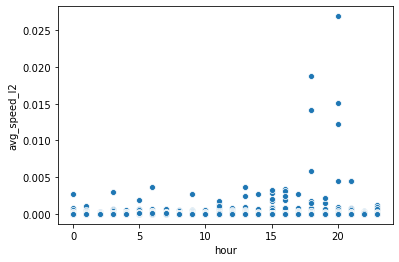

In [205]:
sns.scatterplot(x='hour', y='avg_speed_l2',data=data)

# 4. 기타 전처리 (형 변환)

In [206]:
data.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                float64
log_trip_duration            float64
distance_travel_l1           float64
distance_travel_l2           float64
year                           int64
month                          int64
date                           int64
weekday                        int64
holiday                        int64
hour                           int64
minute                         int64
time                         float64
kmeans                         int32
avg_speed_l2                 float64
dtype: object

"Object" 타입을 변형해줘야함

In [207]:
data['store_and_fwd_flag']
data.replace(to_replace='N', value=0, inplace=True)
data.replace(to_replace='Y', value=1, inplace=True)

In [208]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,year,month,date,weekday,holiday,hour,minute,time,kmeans,avg_speed_l2
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,2016,3,14,0,0,17,24,17.400000,4,0.000039
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,2016,6,12,6,1,0,43,0.716667,8,0.000031
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,2016,1,19,1,0,11,35,11.583333,8,0.000028
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,...,2016,4,6,2,0,19,32,19.533333,8,0.000031
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,...,2016,3,26,5,1,13,30,13.500000,4,0.000025


# 5. Other EDA

<AxesSubplot:>

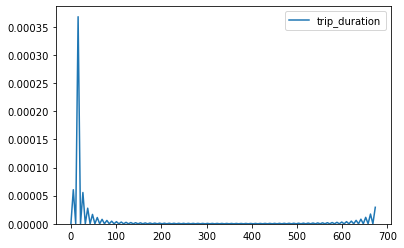

In [209]:
fig=plt.figure()
train.trip_duration=(train.trip_duration-np.mean(train.trip_duration))/(np.std(train.trip_duration))
sns.kdeplot(train['trip_duration'])

<AxesSubplot:>

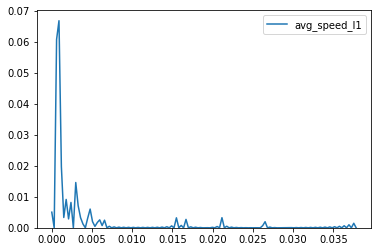

In [210]:
data['avg_speed_l1']=data['distance_travel_l1']/data['trip_duration']
sns.kdeplot(data['avg_speed_l1'])

## 1) 속도의 차이는 어디에서 올까? (교통체증 발생)

### (1) 어느 지역에 교통체증이 발생할까?

하단 그래프를 보면 latitude 41부근, longitude -75 부근에 pickup 과 dropoff 가 특히 많은것으로 보인다.   
이는 해당 지역이 유동인구가 많은 지역이라 스팟으로의 이동이 몰려있는것이라고 합리적으로 추론할 수 있다.

<AxesSubplot:xlabel='dropoff_latitude', ylabel='avg_speed_l2'>

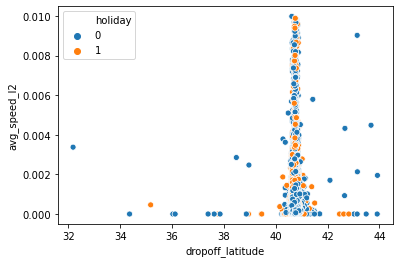

In [418]:
sns.scatterplot(x='dropoff_latitude', y='avg_speed_l2',hue='holiday', x_bins=40, data=data)

<AxesSubplot:xlabel='pickup_latitude', ylabel='avg_speed_l2'>

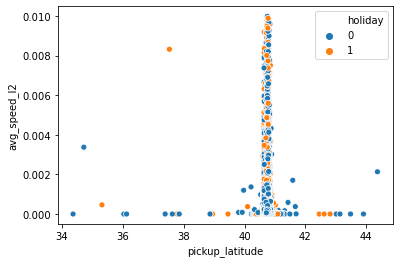

In [419]:
sns.scatterplot(x='pickup_latitude', y='avg_speed_l2',hue='holiday', data=data)

<AxesSubplot:xlabel='pickup_longitude', ylabel='avg_speed_l2'>

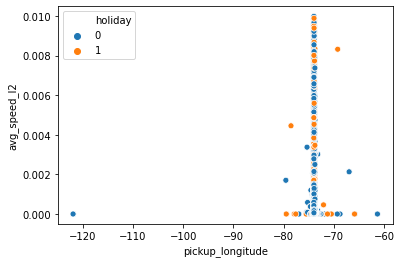

In [420]:
sns.scatterplot(x='pickup_longitude', y='avg_speed_l2',hue='holiday', data=data)

<AxesSubplot:xlabel='dropoff_longitude', ylabel='avg_speed_l2'>

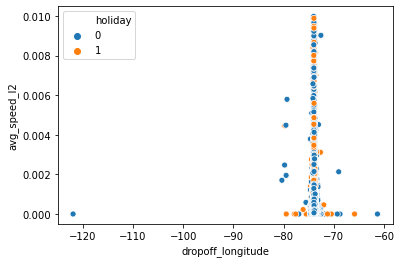

In [421]:
sns.scatterplot(x='dropoff_longitude', y='avg_speed_l2',hue='holiday', data=data)

<AxesSubplot:xlabel='dropoff_latitude'>

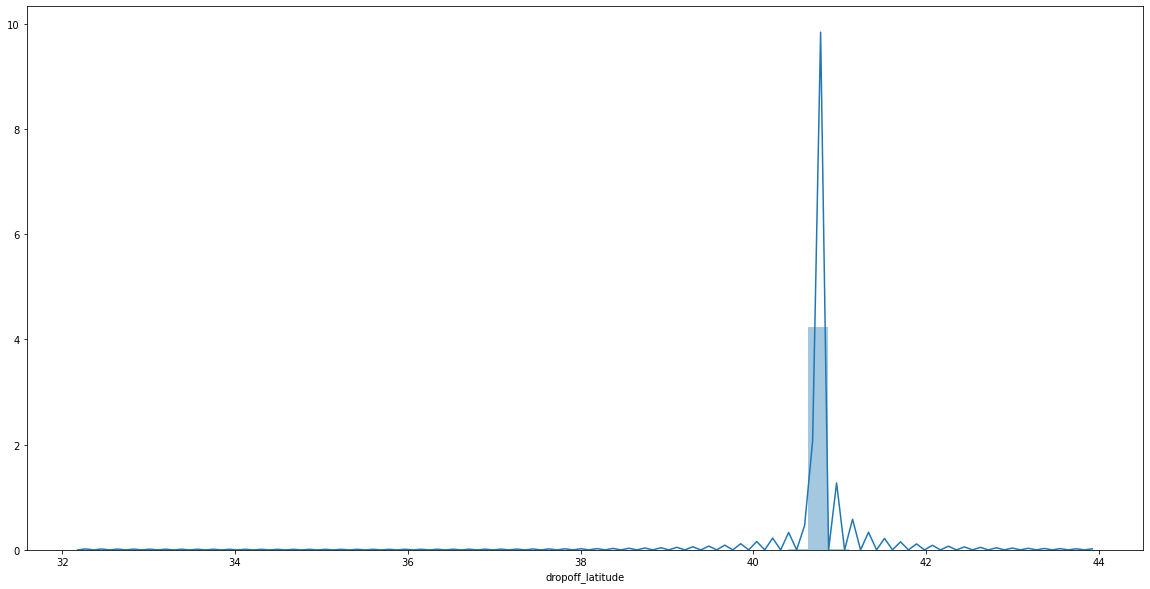

In [426]:
plt.figure(figsize=(20,10))
sns.distplot(train['dropoff_latitude'])

<AxesSubplot:xlabel='dropoff_longitude'>

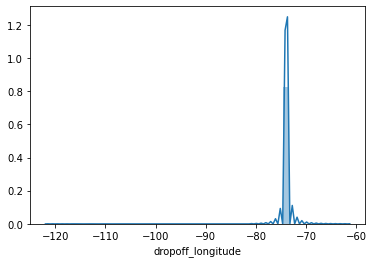

In [427]:
sns.distplot(train['dropoff_longitude'])

### (2) 어느 시간대에 발생할까?

<AxesSubplot:xlabel='hour', ylabel='avg_speed_l2'>

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


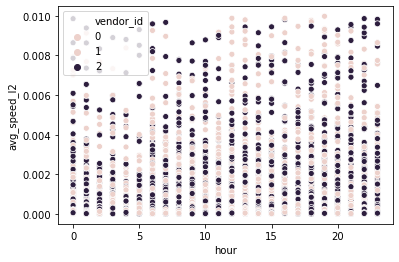

In [428]:
sns.scatterplot(x='hour', y='avg_speed_l2',hue='vendor_id',data=data)

In [429]:
dawn=(data['hour']>=0)&(data['hour']<5)
morning=(data['hour']>=5)&(data['hour']<10)
noon=(data['hour']>=10)&(data['hour']<15)
evening=(data['hour']>=15)&(data['hour']<20)
night=(data['hour']>=20)

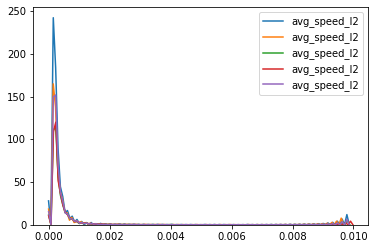

In [430]:
fig=plt.figure()
for i in [dawn, morning, noon, evening, night]:
    sns.kdeplot(data.loc[i, 'avg_speed_l2'])

In [431]:
for i in [dawn, morning, noon, evening, night]:
    print(np.mean(data.loc[i, 'avg_speed_l2']))

6.529607310435346e-05
5.4283242536961816e-05
4.720868463075994e-05
4.838500733480354e-05
5.670593620412711e-05


<AxesSubplot:>

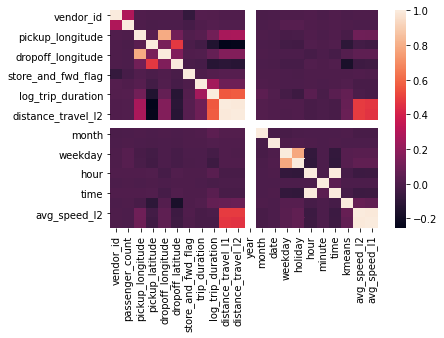

In [211]:
sns.heatmap(data.corr())

# 3. Model

In [ ]:
x_train

## 1) data 정리하기 (X, Y, Train, Test, Validation)

In [212]:
data.head()
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'log_trip_duration', 'distance_travel_l1',
       'distance_travel_l2', 'year', 'month', 'date', 'weekday', 'holiday',
       'hour', 'minute', 'time', 'kmeans', 'avg_speed_l2', 'avg_speed_l1'],
      dtype='object')

In [213]:
feature=['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude',
       'distance_travel_l1', 'distance_travel_l2', 'year',
       'month', 'date', 'weekday', 'holiday','time',
       'kmeans']

In [214]:
train=data.iloc[:1458643,:]
test=data.iloc[1458644:,:]

In [217]:
print(test.shape, raw_test.shape)

(625134, 25) (625134, 9)


In [218]:
train.isna().sum()
train.dropna(how='any', inplace=True)

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [219]:
test.isna().sum()

id                         0
vendor_id                  0
pickup_datetime            0
dropoff_datetime      625134
passenger_count            0
pickup_longitude           0
pickup_latitude            0
dropoff_longitude          0
dropoff_latitude           0
store_and_fwd_flag         0
trip_duration         625134
log_trip_duration     625134
distance_travel_l1         0
distance_travel_l2         0
year                       0
month                      0
date                       0
weekday                    0
holiday                    0
hour                       0
minute                     0
time                       0
kmeans                     0
avg_speed_l2          625134
avg_speed_l1          625134
dtype: int64

In [220]:
x_train=train[feature]
y_train=train['log_trip_duration'].values
x_test=test[feature]
x_test.isna().sum()

vendor_id             0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
distance_travel_l1    0
distance_travel_l2    0
year                  0
month                 0
date                  0
weekday               0
holiday               0
time                  0
kmeans                0
dtype: int64

In [221]:
print(train.shape, test.shape, x_train.shape, y_train.shape)

(1458643, 25) (625134, 25) (1458643, 15) (1458643,)


In [222]:
x_pre_train, x_val, y_pre_train, y_val=sklearn.model_selection.train_test_split(x_train, y_train, test_size=0.2)

In [223]:
x_pre_train.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance_travel_l1,distance_travel_l2,year,month,date,weekday,holiday,time,kmeans
1089277,2,1,-73.995354,40.688110,-73.959602,40.675716,0.048145,0.037839,2016,5,6,4,0,23.866667,8
1095570,2,6,-73.970589,40.757992,-73.984032,40.765125,0.020576,0.015218,2016,6,25,5,1,17.766667,0
102067,2,1,-74.006943,40.752941,-73.931587,40.796089,0.118504,0.086834,2016,5,4,2,0,20.983333,4
1038376,1,1,-73.901268,40.745754,-73.912720,40.755798,0.021496,0.015232,2016,5,17,1,0,2.316667,5
608093,2,1,-73.978813,40.762520,-73.955902,40.767982,0.028374,0.023553,2016,4,5,1,0,21.850000,4


In [224]:
x_val.shape
x_val.isna().sum()

vendor_id             0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
distance_travel_l1    0
distance_travel_l2    0
year                  0
month                 0
date                  0
weekday               0
holiday               0
time                  0
kmeans                0
dtype: int64

In [225]:
x_val.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance_travel_l1,distance_travel_l2,year,month,date,weekday,holiday,time,kmeans
599897,2,1,-73.989922,40.734169,-73.988892,40.733910,0.001289,0.001062,2016,4,15,4,0,0.450000,8
766206,2,1,-73.972229,40.757431,-73.984879,40.758926,0.014145,0.012738,2016,6,4,5,1,22.266667,0
281400,1,1,-74.005722,40.740036,-73.977470,40.751999,0.040215,0.030680,2016,6,18,5,1,2.533333,0
810569,1,1,-73.974327,40.788601,-73.954338,40.787346,0.021244,0.020028,2016,4,24,6,1,1.316667,4
1421545,2,1,-73.981720,40.743263,-73.987381,40.763840,0.026237,0.021341,2016,6,25,5,1,23.300000,0


In [226]:
import xgboost as xgb

data_tr  = xgb.DMatrix(x_pre_train, label=y_pre_train)
data_cv  = xgb.DMatrix(x_val, label=y_val)
evallist = [(data_tr, 'train'), (data_cv, 'valid')]

In [227]:
parms = {'max_depth':8, #maximum depth of a tree
         'objective':'reg:linear',
         'eta'      :0.3,
         'subsample':0.8,#SGD will use this percentage of data
         'lambda '  :4, #L2 regularization term,>1 more conservative 
         'colsample_bytree ':0.9,
         'colsample_bylevel':1,
         'min_child_weight': 10,
         'nthread'  :3}  #number of cpu core to use

model = xgb.train(parms, data_tr, num_boost_round=1000, evals = evallist,
                  early_stopping_rounds=30, maximize=False, 
                  verbose_eval=100)

print('score = %1.5f, n_boost_round =%d.'%(model.best_score,model.best_iteration))

[20:25:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[20:25:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/learner.cc:480: 
Parameters: { colsample_bytree , lambda  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:0.88280	valid-rmse:0.88113
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[100]	train-rmse:0.46785	valid-rmse:0.49886
[200]	train-rmse:0.44806	valid-rmse:0.49822
Stopping. Best iteration:
[175]	train-rmse:0.45182	valid-rmse:0.49786

[20:26:40] WARNING: /home/conda/feedstock_root/build_ar

In [228]:
print('score = %1.5f, n_boost_round =%d.'%(model.best_score,model.best_iteration))

score = 0.49786, n_boost_round =175.


In [229]:
data_test = xgb.DMatrix(x_test)
ztest = model.predict(data_test)

In [230]:
ytest = np.exp(ztest)-1
print(ytest[:10])
submission = pd.DataFrame({'id': test.id, 'trip_duration': ytest}).set_index('id')

[ 0.3728     -0.22126657 -0.35067403  0.6500857  -0.50779307  0.5024377
  1.1453626   0.49657106  5.4374685  -0.22366089]


In [231]:
submission.to_csv(path+'submission_1.csv')

In [232]:
submission.head()

,trip_duration
id,
id3004672,0.372800
id3505355,-0.221267
id1217141,-0.350674
id2150126,0.650086
id1598245,-0.507793


In [233]:
len(submission)

625134